# ***Mount Google Drive***

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***IMPORTS***

In [ ]:
# Core
import os
import numpy as np

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Sklearn
from sklearn.utils.class_weight import compute_class_weight



# ***Paths (EDIT THESE ONLY)***

In [ ]:

TRAIN_DIR = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Train"
TEST_DIR  = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Test"

MODEL_SAVE_PATH = "/content/drive/MyDrive/Project work/models/Tumor_v2s_clean.keras"


In [ ]:
os.path.exists(TRAIN_DIR)
os.path.exists(TEST_DIR)

True

# ***Config***

In [ ]:
IMG_SIZE = 384
BATCH_SIZE = 16
SEED = 42

WARMUP_EPOCHS = 3
HEAD_EPOCHS   = 5
FT1_EPOCHS    = 6
FT2_EPOCHS    = 4

TARGET_ACC = 0.90
GRAPHS=[]

# ***===============================***
# ***DATA LOADING***
# ***===============================***

# ***LOAD TRAIN + VAL***

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names     # ✅ FIX ADDED
NUM_CLASSES = len(class_names)

print("Classes:", class_names)


Found 9650 files belonging to 4 classes.
Using 7720 files for training.
Found 9650 files belonging to 4 classes.
Using 1930 files for validation.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# ***LOAD TEST***

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)


Found 2180 files belonging to 4 classes.


# ***PREFETCH***

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


# ***AUGMENTATION***

In [ ]:
augment = tf.keras.Sequential([

    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.15),
    tf.keras.layers.RandomBrightness(0.1)

])
train_ds = train_ds.map(
    lambda x, y: (augment(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)



# ***CLASS WEIGHTS***

In [ ]:
labels = []

for _, y in train_ds:
    labels.extend(np.argmax(y.numpy(), axis=1))

labels = np.array(labels)

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))

print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.8004977187888843), 1: np.float64(1.107921928817451), 2: np.float64(1.238767650834403), 3: np.float64(0.9606769537083126)}


# ***CALLBACKS***

In [ ]:
callbacks = [

    tf.keras.callbacks.ModelCheckpoint(
        "best_temp.h5",
        monitor="val_loss",
        save_best_only=True
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.3,
        min_lr=1e-6
    )
]


# ***BUILD MODEL***

In [ ]:
base_model = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False


inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

x = preprocess_input(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation="swish")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(
    NUM_CLASSES,
    activation="softmax"
)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 12, 12, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,665,444 (78.83 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

LOSS & METRICS

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

metrics = [
    "accuracy",
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]


# ***WARMUP (3)***

In [ ]:
print("Warmup...")

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    loss=loss_fn,
    metrics=metrics
)

hist_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=WARMUP_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_temp.h5")
GRAPHS.append(hist_warmup)

Warmup...
Epoch 1/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6767 - loss: 1.1302 - precision_1: 0.7058 - recall_1: 0.6278

483/483 ━━━━━━━━━━━━━━━━━━━━ 180s 264ms/step - accuracy: 0.6769 - loss: 1.1298 - precision_1: 0.7059 - recall_1: 0.6280 - val_accuracy: 0.8352 - val_loss: 0.6877 - val_precision_1: 0.8718 - val_recall_1: 0.7819 - learning_rate: 0.0010
Epoch 2/3
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8077 - loss: 0.7305 - precision_1: 0.8520 - recall_1: 0.7616

483/483 ━━━━━━━━━━━━━━━━━━━━ 48s 98ms/step - accuracy: 0.8077 - loss: 0.7304 - precision_1: 0.8521 - recall_1: 0.7617 - val_accuracy: 0.8782 - val_loss: 0.6640 - val_precision_1: 0.9046 - val_recall_1: 0.8352 - learning_rate: 0.0010
Epoch 3/3
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8506 - loss: 0.6614 - precision_1: 0.8915 - recall_1: 0.7963

483/483 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.8506 - loss: 0.6613 - precision_1: 0.8915 - recall_1: 0.7963 - val_accuracy: 0.8876 - val_loss: 0.5994 - val_precision_1: 0.9146 - val_recall_1: 0.8601 - learning_rate: 0.0010


HEAD TRAINING (5)

In [ ]:
print("Head Training...")

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    loss=loss_fn,
    metrics=metrics
)

hist_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_temp.h5")
GRAPHS.append(hist_head)

Head Training...
Epoch 1/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 149s 202ms/step - accuracy: 0.8349 - loss: 0.6863 - precision_1: 0.8934 - recall_1: 0.8163 - val_accuracy: 0.8813 - val_loss: 0.6256 - val_precision_1: 0.9036 - val_recall_1: 0.8358 - learning_rate: 0.0010
Epoch 2/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 47s 96ms/step - accuracy: 0.8545 - loss: 0.6418 - precision_1: 0.8925 - recall_1: 0.8066 - val_accuracy: 0.8870 - val_loss: 0.6086 - val_precision_1: 0.9105 - val_recall_1: 0.8596 - learning_rate: 0.0010
Epoch 3/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8645 - loss: 0.6278 - precision_1: 0.9032 - recall_1: 0.8136

483/483 ━━━━━━━━━━━━━━━━━━━━ 48s 98ms/step - accuracy: 0.8645 - loss: 0.6277 - precision_1: 0.9032 - recall_1: 0.8136 - val_accuracy: 0.9119 - val_loss: 0.5548 - val_precision_1: 0.9406 - val_recall_1: 0.8855 - learning_rate: 0.0010
Epoch 4/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 47s 96ms/step - accuracy: 0.8788 - loss: 0.6096 - precision_1: 0.9117 - recall_1: 0.8252 - val_accuracy: 0.9052 - val_loss: 0.5690 - val_precision_1: 0.9244 - val_recall_1: 0.8808 - learning_rate: 0.0010
Epoch 5/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8772 - loss: 0.6166 - precision_1: 0.9129 - recall_1: 0.8324

483/483 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.8772 - loss: 0.6165 - precision_1: 0.9129 - recall_1: 0.8324 - val_accuracy: 0.9254 - val_loss: 0.5430 - val_precision_1: 0.9440 - val_recall_1: 0.8995 - learning_rate: 0.0010


FT1 (50% — 6)

In [ ]:
print("Fine-Tune 50%...")


n = len(base_model.layers)
unfreeze = int(0.5 * n)

for layer in base_model.layers[unfreeze:]:
    layer.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.AdamW(5e-5),
    loss=loss_fn,
    metrics=metrics
)

hist_ft1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT1_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_temp.h5")
GRAPHS.append(hist_ft1)

Fine-Tune 50%...
Epoch 1/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9849 - loss: 0.4208 - precision_1: 0.9894 - recall_1: 0.9732

483/483 ━━━━━━━━━━━━━━━━━━━━ 235s 277ms/step - accuracy: 0.9849 - loss: 0.4208 - precision_1: 0.9894 - recall_1: 0.9732 - val_accuracy: 0.9860 - val_loss: 0.4131 - val_precision_1: 0.9896 - val_recall_1: 0.9845 - learning_rate: 5.0000e-05
Epoch 2/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9887 - loss: 0.4067 - precision_1: 0.9933 - recall_1: 0.9839

483/483 ━━━━━━━━━━━━━━━━━━━━ 57s 116ms/step - accuracy: 0.9887 - loss: 0.4067 - precision_1: 0.9933 - recall_1: 0.9839 - val_accuracy: 0.9870 - val_loss: 0.3991 - val_precision_1: 0.9901 - val_recall_1: 0.9834 - learning_rate: 5.0000e-05
Epoch 3/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9890 - loss: 0.4046 - precision_1: 0.9919 - recall_1: 0.9826

483/483 ━━━━━━━━━━━━━━━━━━━━ 57s 116ms/step - accuracy: 0.9890 - loss: 0.4046 - precision_1: 0.9919 - recall_1: 0.9826 - val_accuracy: 0.9876 - val_loss: 0.3939 - val_precision_1: 0.9906 - val_recall_1: 0.9860 - learning_rate: 5.0000e-05
Epoch 4/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 55s 113ms/step - accuracy: 0.9924 - loss: 0.3955 - precision_1: 0.9956 - recall_1: 0.9871 - val_accuracy: 0.9870 - val_loss: 0.3949 - val_precision_1: 0.9901 - val_recall_1: 0.9850 - learning_rate: 5.0000e-05
Epoch 5/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9938 - loss: 0.3923 - precision_1: 0.9973 - recall_1: 0.9873

483/483 ━━━━━━━━━━━━━━━━━━━━ 56s 114ms/step - accuracy: 0.9938 - loss: 0.3923 - precision_1: 0.9973 - recall_1: 0.9873 - val_accuracy: 0.9855 - val_loss: 0.3932 - val_precision_1: 0.9870 - val_recall_1: 0.9850 - learning_rate: 5.0000e-05
Epoch 6/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9942 - loss: 0.3879 - precision_1: 0.9949 - recall_1: 0.9912

483/483 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.9942 - loss: 0.3879 - precision_1: 0.9949 - recall_1: 0.9913 - val_accuracy: 0.9896 - val_loss: 0.3829 - val_precision_1: 0.9906 - val_recall_1: 0.9881 - learning_rate: 5.0000e-05


FT2 (IF ACC < 90%)

In [ ]:
# @title
best_val = max(hist_ft1.history["val_accuracy"])

print("Best Val Acc:", best_val)


if best_val < TARGET_ACC:

    print("Running Full Fine-Tuning...")


    base_model.trainable = True


    model.compile(
        optimizer=tf.keras.optimizers.AdamW(2e-5),
        loss=loss_fn,
        metrics=metrics
    )


    hist_ft2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FT2_EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights
    )


    model.load_weights("best_temp.h5")
    GRAPHS.append(hist_ft2)

else:

    print("Skipping FT2 (Accuracy ≥ 90%)")


Best Val Acc: 0.9896373152732849
Skipping FT2 (Accuracy ≥ 90%)


# ***GRAPH***

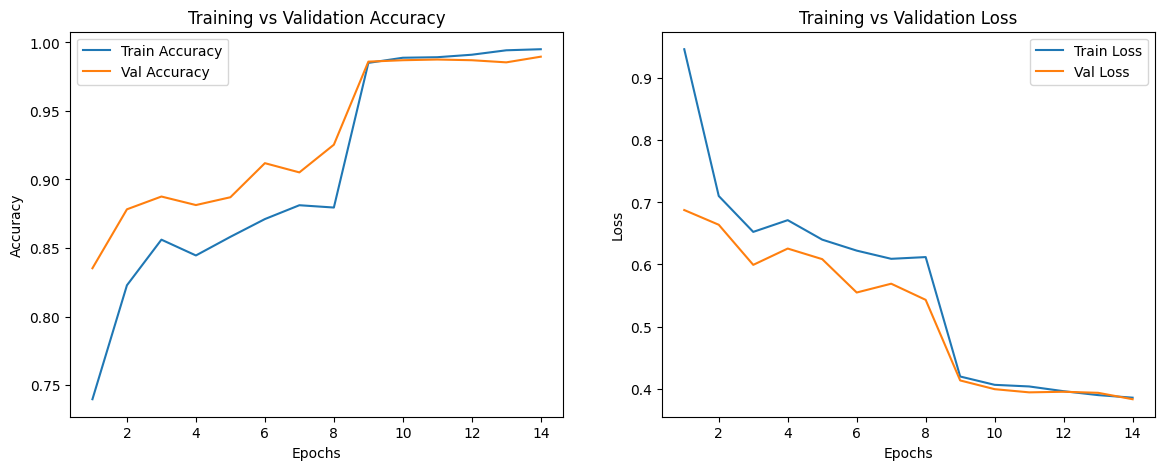

In [ ]:
# ===============================
# TRAINING GRAPH
# ===============================

import matplotlib.pyplot as plt


def plot_history(histories):

    train_acc = []
    val_acc   = []
    train_loss = []
    val_loss   = []


    for h in histories:

        train_acc  += h.history["accuracy"]
        val_acc    += h.history["val_accuracy"]

        train_loss += h.history["loss"]
        val_loss   += h.history["val_loss"]


    epochs = range(1, len(train_acc) + 1)


    plt.figure(figsize=(14,5))


    # Accuracy Plot
    plt.subplot(1,2,1)

    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")

    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.legend()


    # Loss Plot
    plt.subplot(1,2,2)

    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")

    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.legend()


    plt.show()

plot_history(GRAPHS)


# ***CONFUSION MATRIX***

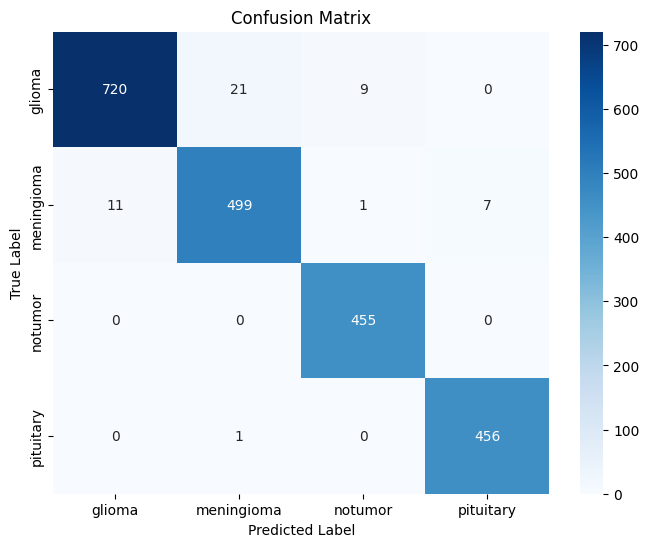

Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       750
  meningioma       0.96      0.96      0.96       518
     notumor       0.98      1.00      0.99       455
   pituitary       0.98      1.00      0.99       457

    accuracy                           0.98      2180
   macro avg       0.98      0.98      0.98      2180
weighted avg       0.98      0.98      0.98      2180



In [ ]:
# ===============================
# CONFUSION MATRIX
# ===============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


y_true = []
y_pred = []


# Get predictions
for x, y in test_ds:

    preds = model.predict(x, verbose=0)

    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


y_true = np.array(y_true)
y_pred = np.array(y_pred)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8,6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()


# Classification Report
print("Classification Report:\n")

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


# ***EVALUATE***

In [ ]:
print("Evaluating on Test Set...")

model.evaluate(test_ds)


Evaluating on Test Set...
137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.9778 - loss: 0.4035 - precision_1: 0.9809 - recall_1: 0.9724


[0.40567225217819214,
 0.9770641922950745,
 0.980555534362793,
 0.9715596437454224]

SAVE MODEL

In [ ]:
# Save in Keras format (recommended)
model.save(MODEL_SAVE_PATH)

# Save in H5 format (backup)
H5_PATH = MODEL_SAVE_PATH.replace(".keras", ".h5")
model.save(H5_PATH)

print("Model saved at:")
print("Keras :", MODEL_SAVE_PATH)
print("H5    :", H5_PATH)


Model saved at:
Keras : /content/drive/MyDrive/Project work/models/Tumor_v2s_clean.keras
H5    : /content/drive/MyDrive/Project work/models/Tumor_v2s_clean.h5
